<a href="https://colab.research.google.com/github/PaVeLlLlLX/Segmentation_Ribs/blob/main/segmentation_ribs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

%%shell
pip install -q cython
pip install -qU 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

pip install gdown
gdown --id 1HGnvRZW-HWkyh7x1_ZlvSAPDcx1OGlNh
gdown --id 1_HrcPnL5HnmG3m6XvQRK2IYAHf5a5mS_
unzip few_data_split.zip

git clone https://github.com/comptech-winter-school/coal-composition-control -b dev


  Preparing metadata (setup.py) ... done
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1HGnvRZW-HWkyh7x1_ZlvSAPDcx1OGlNh

but Gdown can't. Please check connections and permissions.
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_HrcPnL5HnmG3m6XvQRK2IYAHf5a5mS_
To: /content/example.png
100% 1.16M/1.16M [00:00<00:00, 103MB/s]
unzip:  cannot find 

In [21]:
from packaging import version
import numpy as np

if version.parse(np.__version__) >= version.parse("1.24.0"):
  np.float = np.float64

In [22]:
%cd coal-composition-control
!pip install -qU numpy
!pip install -r requirements.txt

/content/coal-composition-control
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 38.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
ERROR: Could not find a version that satisfies the requirement torchvision~=0.11.1 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2)
ERROR: No matching distribution found for torchvision~=0.11.1


In [23]:
import torch
from PIL import Image
from pathlib import Path
from train.instance_segmentation.mask_rcnn_dataset import CoalFractionDataset

In [24]:
import os
import random

def seed_everything(SEED=411, seed_all=False) -> None:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    if seed_all:
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.benchmark = False

In [25]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [26]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.11.0


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 460475, done.
remote: Counting objects: 100% (40934/40934), done.
remote: Compressing objects: 100% (1919/1919), done.
remote: Total 460475 (delta 39039), reused 40795 (delta 38954), pack-reused 419541
Receiving objects: 100% (460475/460475), 904.59 MiB | 31.15 MiB/s, done.
Resolving deltas: 100% (428142/428142), done.
Note: switching to 'v0.11.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 58a60b2eb4 Fixing bug on SSD backbone freezing. (#4591)


In [112]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    #if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        #transforms.append(T.RandomHorizontalFlip(p=0.2))
        #transforms.append(T.RandomPhotometricDistort(p=0.1))

    return T.Compose(transforms)

In [132]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = CoalFractionDataset(
    root='/content/drive/MyDrive/dataset',
    vgg_json='/content/drive/MyDrive/train_ribs_json.json',
    width=1500,
    height=1500,
    transforms=get_transform(train=True)
    )
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [130]:
image = np.array(images[0])
image.astype(np.uint8)
targ = np.array(targets[0]['masks'])
cv2_imshow(targ)

In [101]:
# use our dataset and defined transformations
dataset = CoalFractionDataset(
    root='/content/drive/MyDrive/dataset',
    vgg_json='/content/drive/MyDrive/train_ribs_json.json',
    width=1500,
    height=1500,
    transforms=get_transform(train=True)
    )
dataset_test = CoalFractionDataset(
    root='/content/drive/MyDrive/dataset_test',
    vgg_json='/content/drive/MyDrive/test_ribs_json.json',
    width=1500,
    height=1500,
    transforms=get_transform(train=False)
    )


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

[[152 724]
 [155 673]
 [174 630]
 [196 601]
 [222 583]
 [266 566]
 [319 545]
 [379 534]
 [444 528]
 [485 528]
 [537 531]
 [572 534]
 [618 542]
 [655 561]
 [667 566]
 [662 608]
 [649 620]
 [629 596]
 [583 577]
 [526 566]
 [449 566]
 [380 577]
 [327 585]
 [276 601]
 [238 615]
 [208 637]
 [194 667]
 [190 689]
 [151 725]]


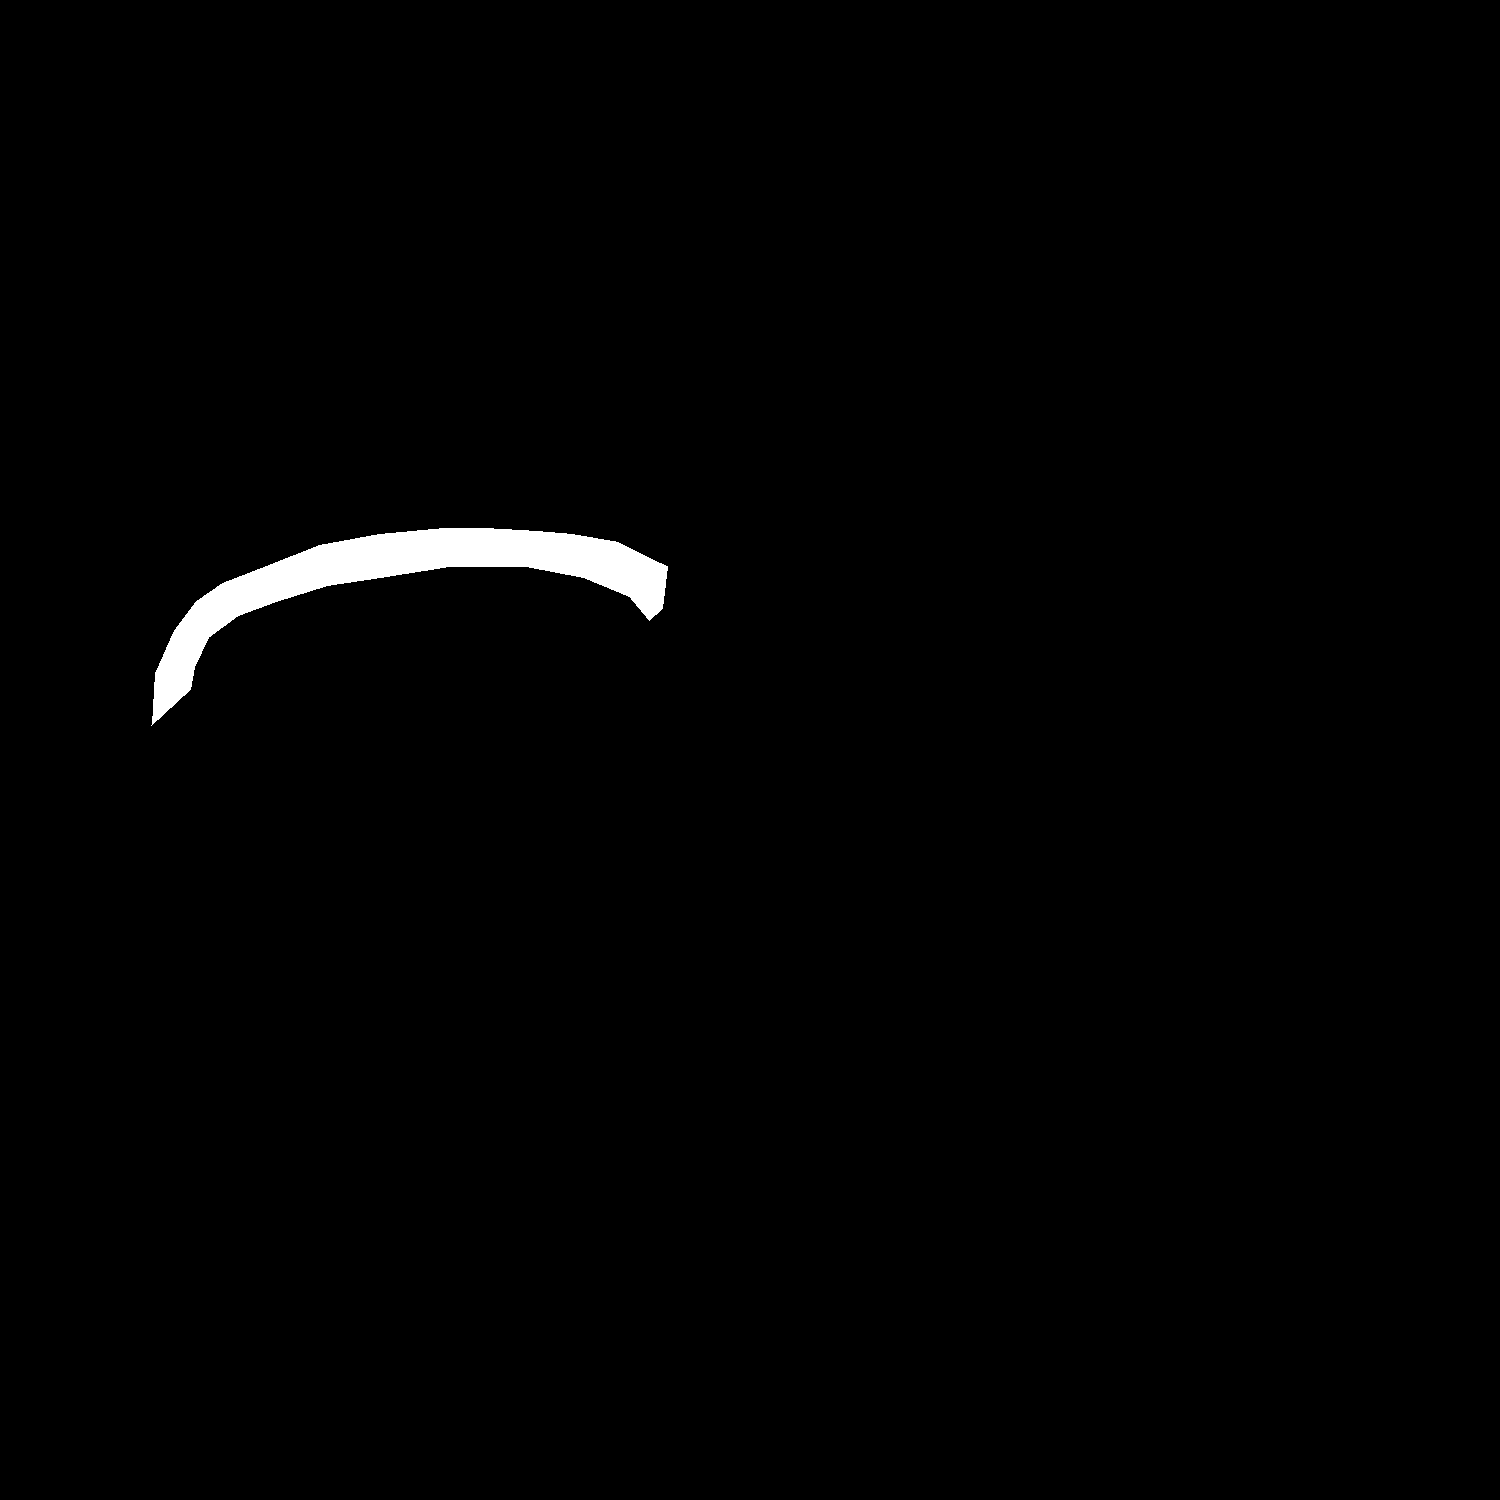

In [138]:
from google.colab.patches import cv2_imshow
mask = dataset.masks['00a2145de1886cb9eb88869c85d74080.dicom.jpg'][0]

blank = np.zeros((1500, 1500))
contours = []
for x in mask:
    contours.append(x)
contours = np.array(contours)
cv2.drawContours(blank, [contours], -1, 255, -1)
cv2_imshow(blank)

In [102]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
import shutil
fol_path = '/content/drive/MyDrive/dataset/.ipynb_checkpoints'
if os.path.exists(fol_path):
  shutil.rmtree(fol_path)

fold_path = '/content/drive/MyDrive/dataset_test/.ipynb_checkpoints'
if os.path.exists(fold_path):
  shutil.rmtree(fold_path)

In [103]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=2)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/8]  eta: 0:00:10  lr: 0.000719  loss: 5.1021 (5.1021)  loss_classifier: 0.7525 (0.7525)  loss_box_reg: 0.0389 (0.0389)  loss_mask: 4.1809 (4.1809)  loss_objectness: 0.1221 (0.1221)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 1.3122  data: 0.7569  max mem: 2882
Epoch: [0]  [2/8]  eta: 0:00:04  lr: 0.002146  loss: 4.0057 (3.4471)  loss_classifier: 0.7525 (0.6808)  loss_box_reg: 0.0389 (0.0459)  loss_mask: 3.1491 (2.6424)  loss_objectness: 0.0470 (0.0681)  loss_rpn_box_reg: 0.0084 (0.0099)  time: 0.7874  data: 0.2863  max mem: 2882
Epoch: [0]  [4/8]  eta: 0:00:02  lr: 0.003573  loss: 1.3064 (2.5035)  loss_classifier: 0.5136 (0.4624)  loss_box_reg: 0.0596 (0.0537)  loss_mask: 1.1269 (1.9238)  loss_objectness: 0.0381 (0.0536)  loss_rpn_box_reg: 0.0084 (0.0099)  time: 0.6486  data: 0.1824  max mem: 2882
Epoch: [0]  [6/8]  eta: 0:00:01  lr: 0.005000  loss: 1.2336 (2.0323)  loss_classifier: 0.1941 (0.3355)  loss_box_reg: 0.0389 (0.0395)  loss_mask: 0.7702 (1.5919)  loss_objectness

In [104]:
model.eval()
model.roi_heads.score_thresh=0.5
model.roi_heads.nms_thresh=0.2

In [105]:
torch.save(model, '/content/drive/MyDrive/mask-rcnn.pth')
# model = torch.load('/content/drive/MyDrive/mask-rcnn.pth')

In [106]:
# pick one image from the test set
img, _ = dataset_test[0]
print(img)
to_tensor = T.ToTensor()
#img, _ = to_tensor(Image.open('/content/drive/MyDrive/3.jpg').convert("RGB"))
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)])

tensor([[[0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0196, 0.0196, 0.0196,  ..., 0.0118, 0.0118, 0.0078]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0196, 0.0196, 0.0196,  ..., 0.0118, 0.0118, 0.0078]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0118, 0.0118, 0.

In [107]:
prediction[0]['masks'].shape
#prediction[0]['boxes'].shape

torch.Size([0, 1, 1500, 1500])

In [108]:
import torchvision.transforms as transforms
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

to_pil_image = transforms.ToPILImage()
byte_img = img.mul(255).byte()

In [109]:
def mask_on_image(byte_img, prediction, th=0.7):
  masks = torch.squeeze(prediction[0]['masks']).cpu()
  print(masks)
  threshold = torch.Tensor([th])
  masks = (masks > threshold).bool()
  masks_on_image = draw_segmentation_masks(
      image = byte_img,
      masks = masks,
      alpha=0.6
      )
  return to_pil_image(masks_on_image)

In [55]:
def box_on_image(byte_img, prediction):
  boxes = torch.squeeze(prediction[0]['boxes'])
  boxes_on_image = draw_bounding_boxes(
      image=byte_img,
      boxes=boxes,
      width=4
      )
  return to_pil_image(boxes_on_image)

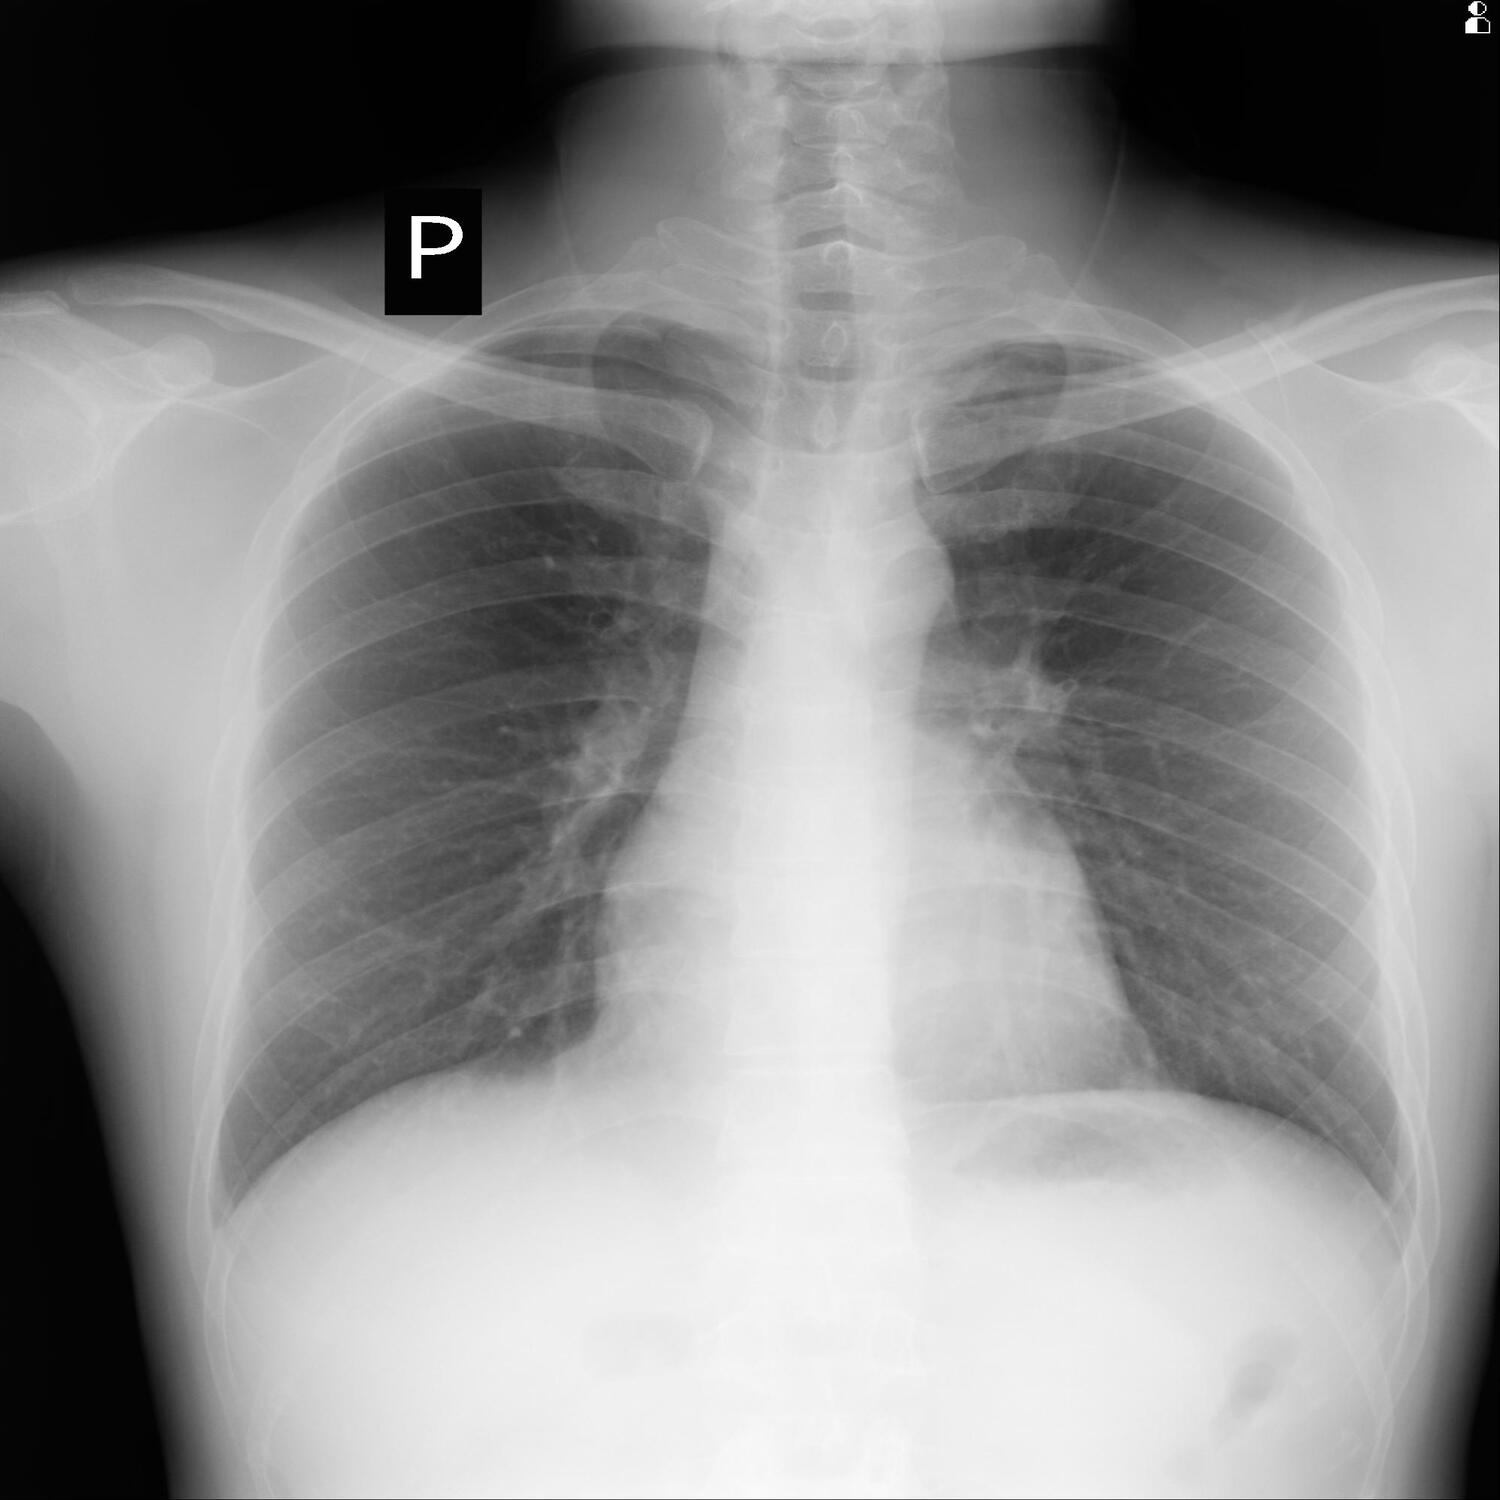

In [110]:
to_pil_image(byte_img)

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


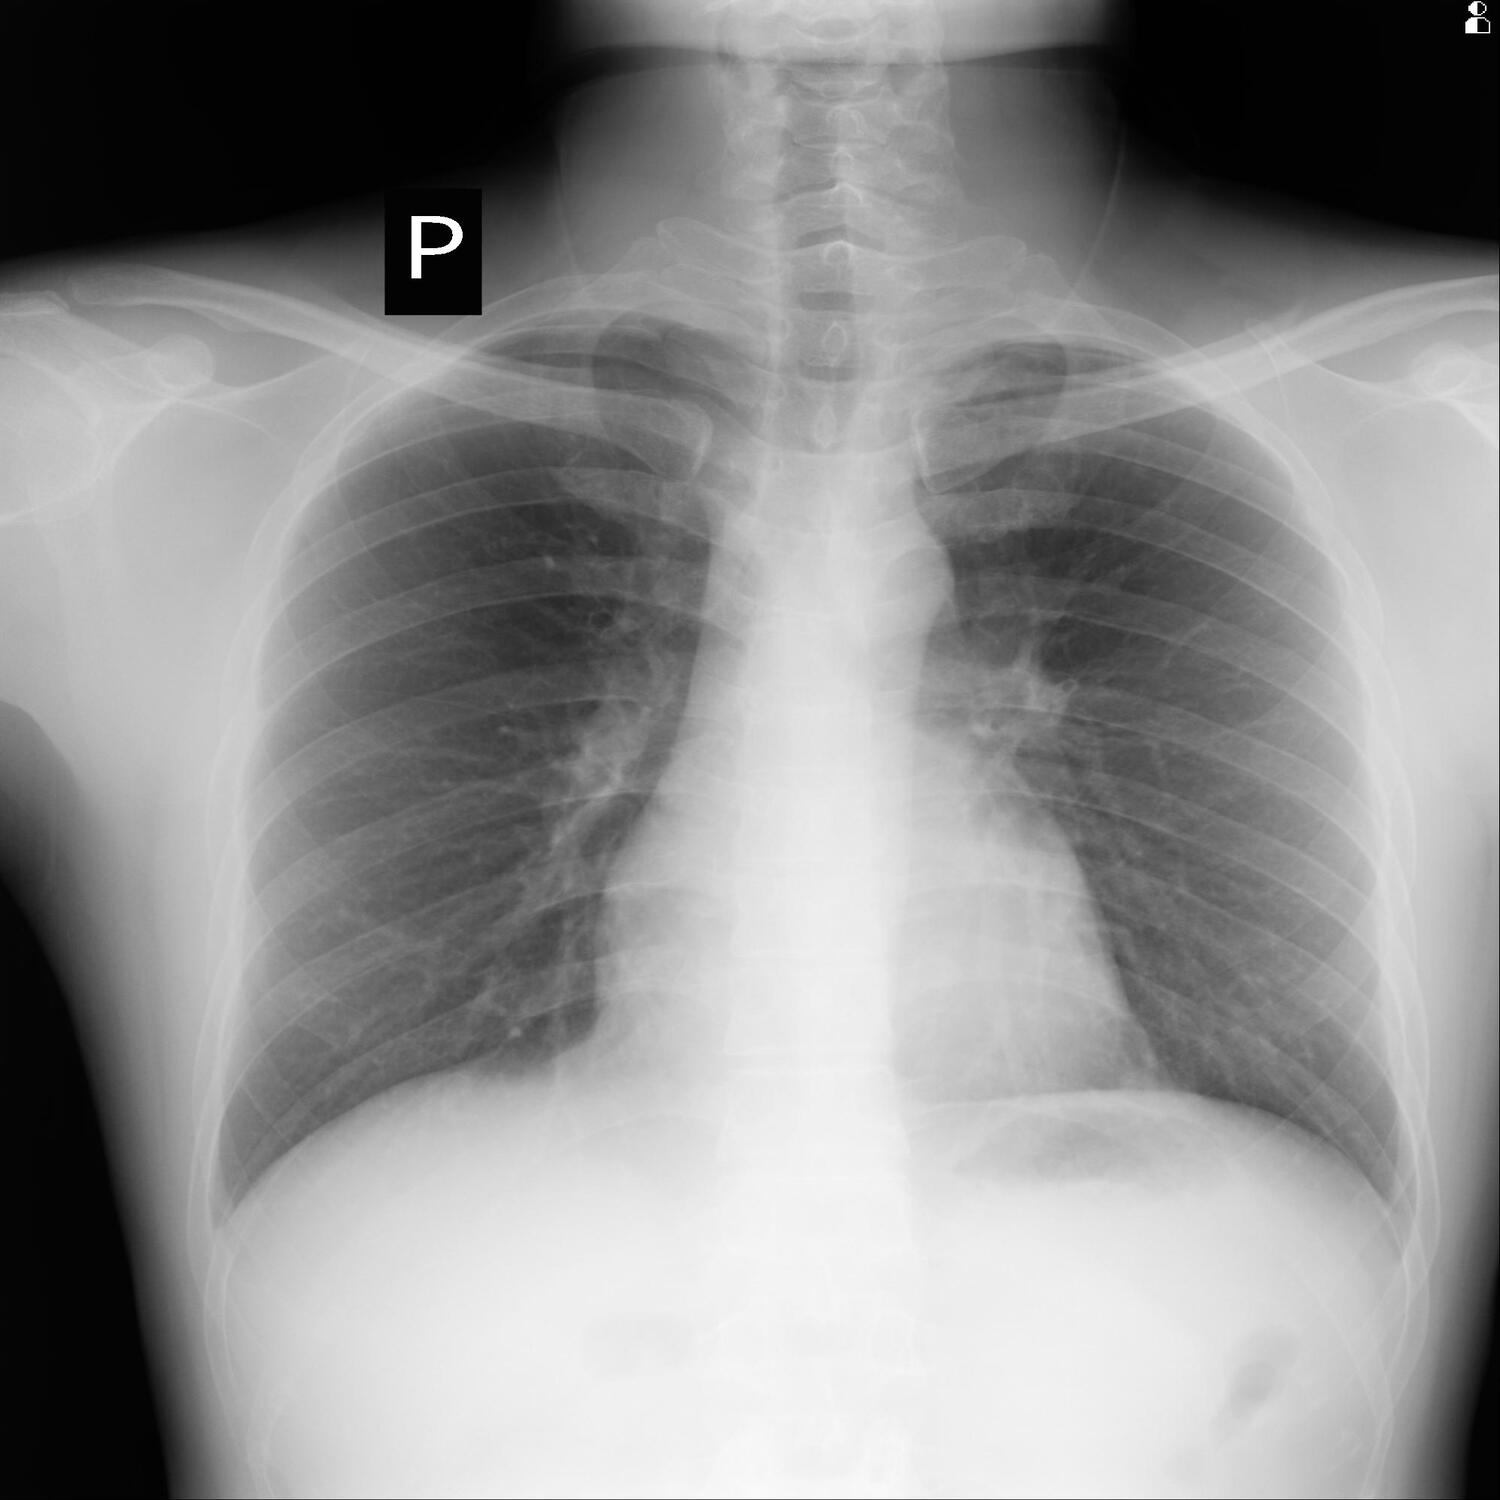

In [111]:
box_on_image(byte_img, prediction)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

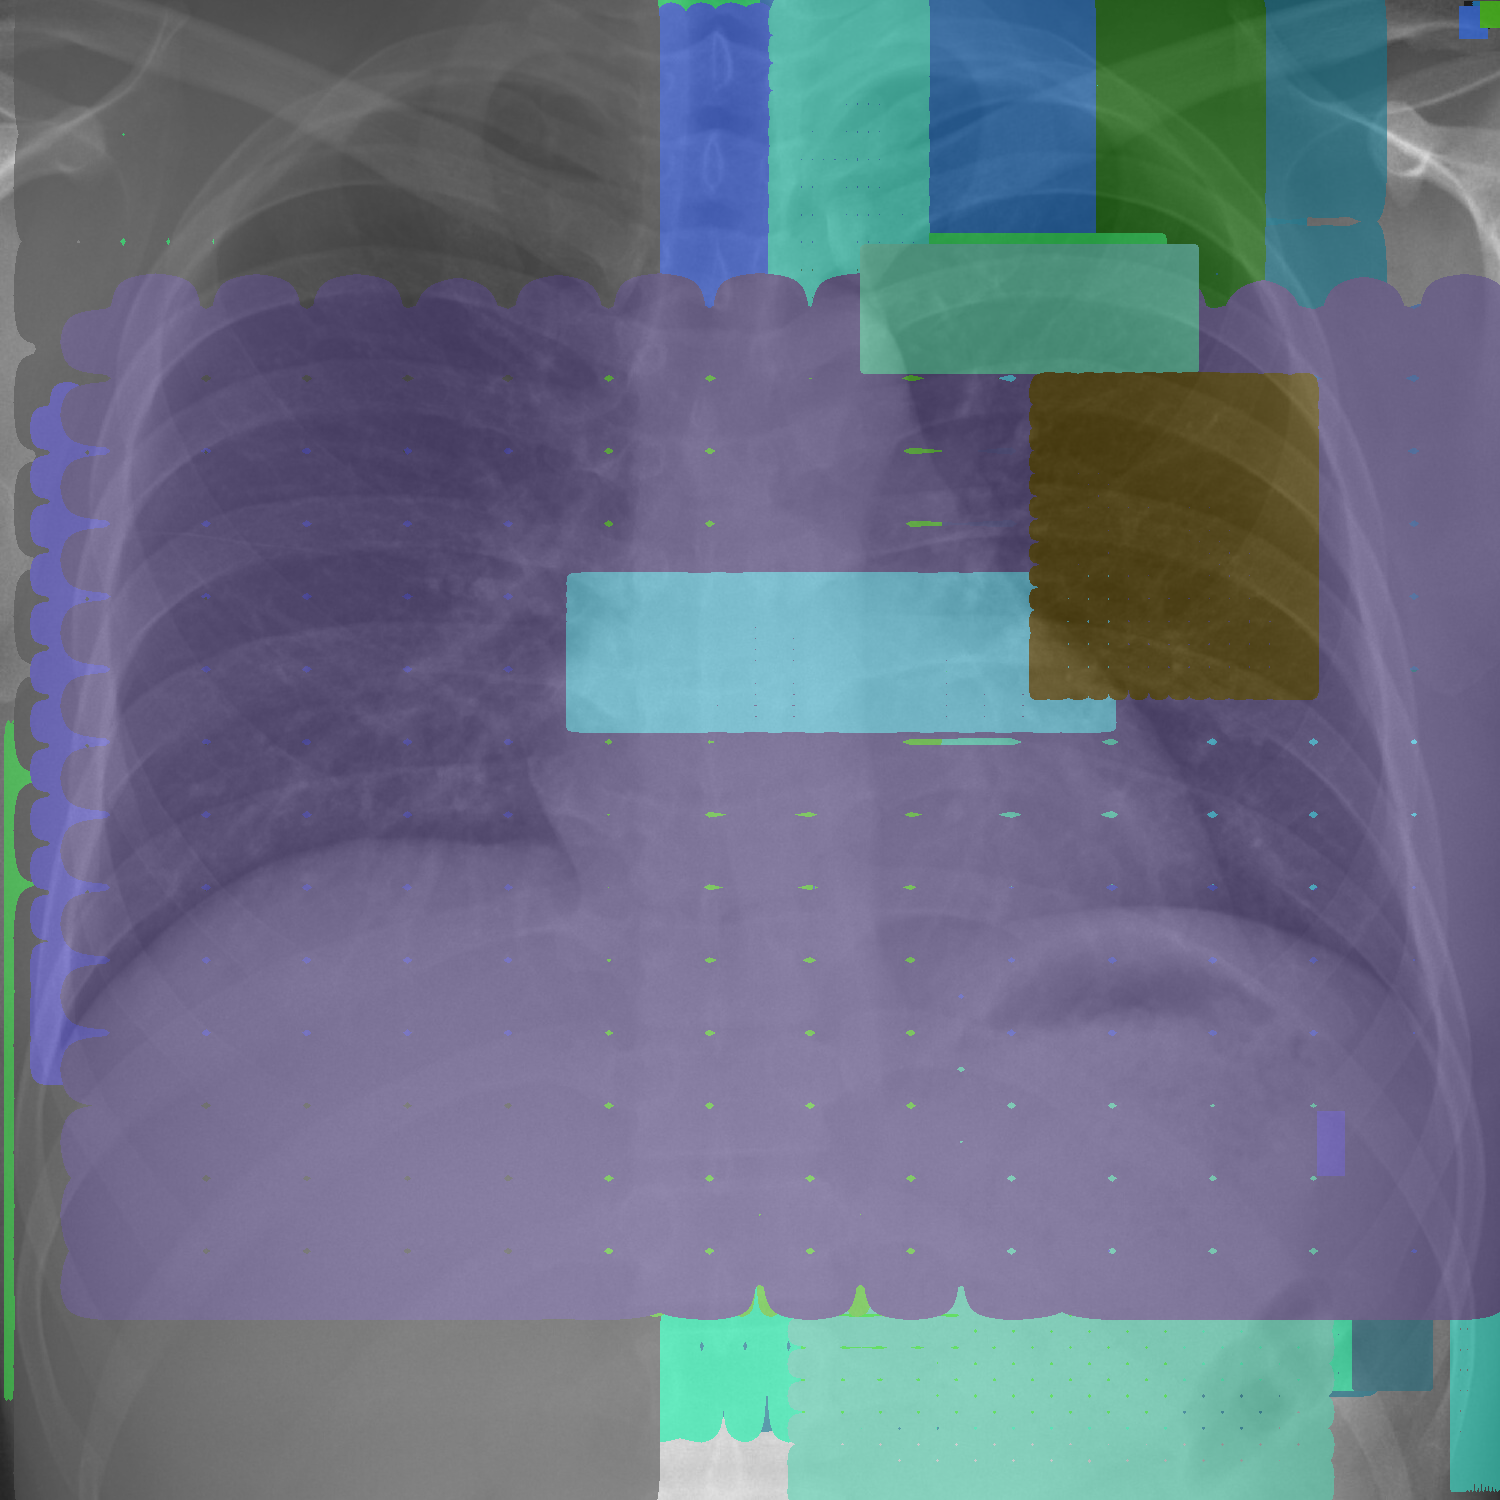

In [93]:
'''
mask_on_image(byte_img, prediction, th=0.9)
mask_on_image(byte_img, prediction, th=0.8)
mask_on_image(byte_img, prediction, th=0.7)
mask_on_image(byte_img, prediction, th=0.6)
mask_on_image(byte_img, prediction, th=0.5)
mask_on_image(byte_img, prediction, th=0.4)
mask_on_image(byte_img, prediction, th=0.3)
mask_on_image(byte_img, prediction, th=0.2)
'''
mask_on_image(byte_img, prediction, th=0.1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

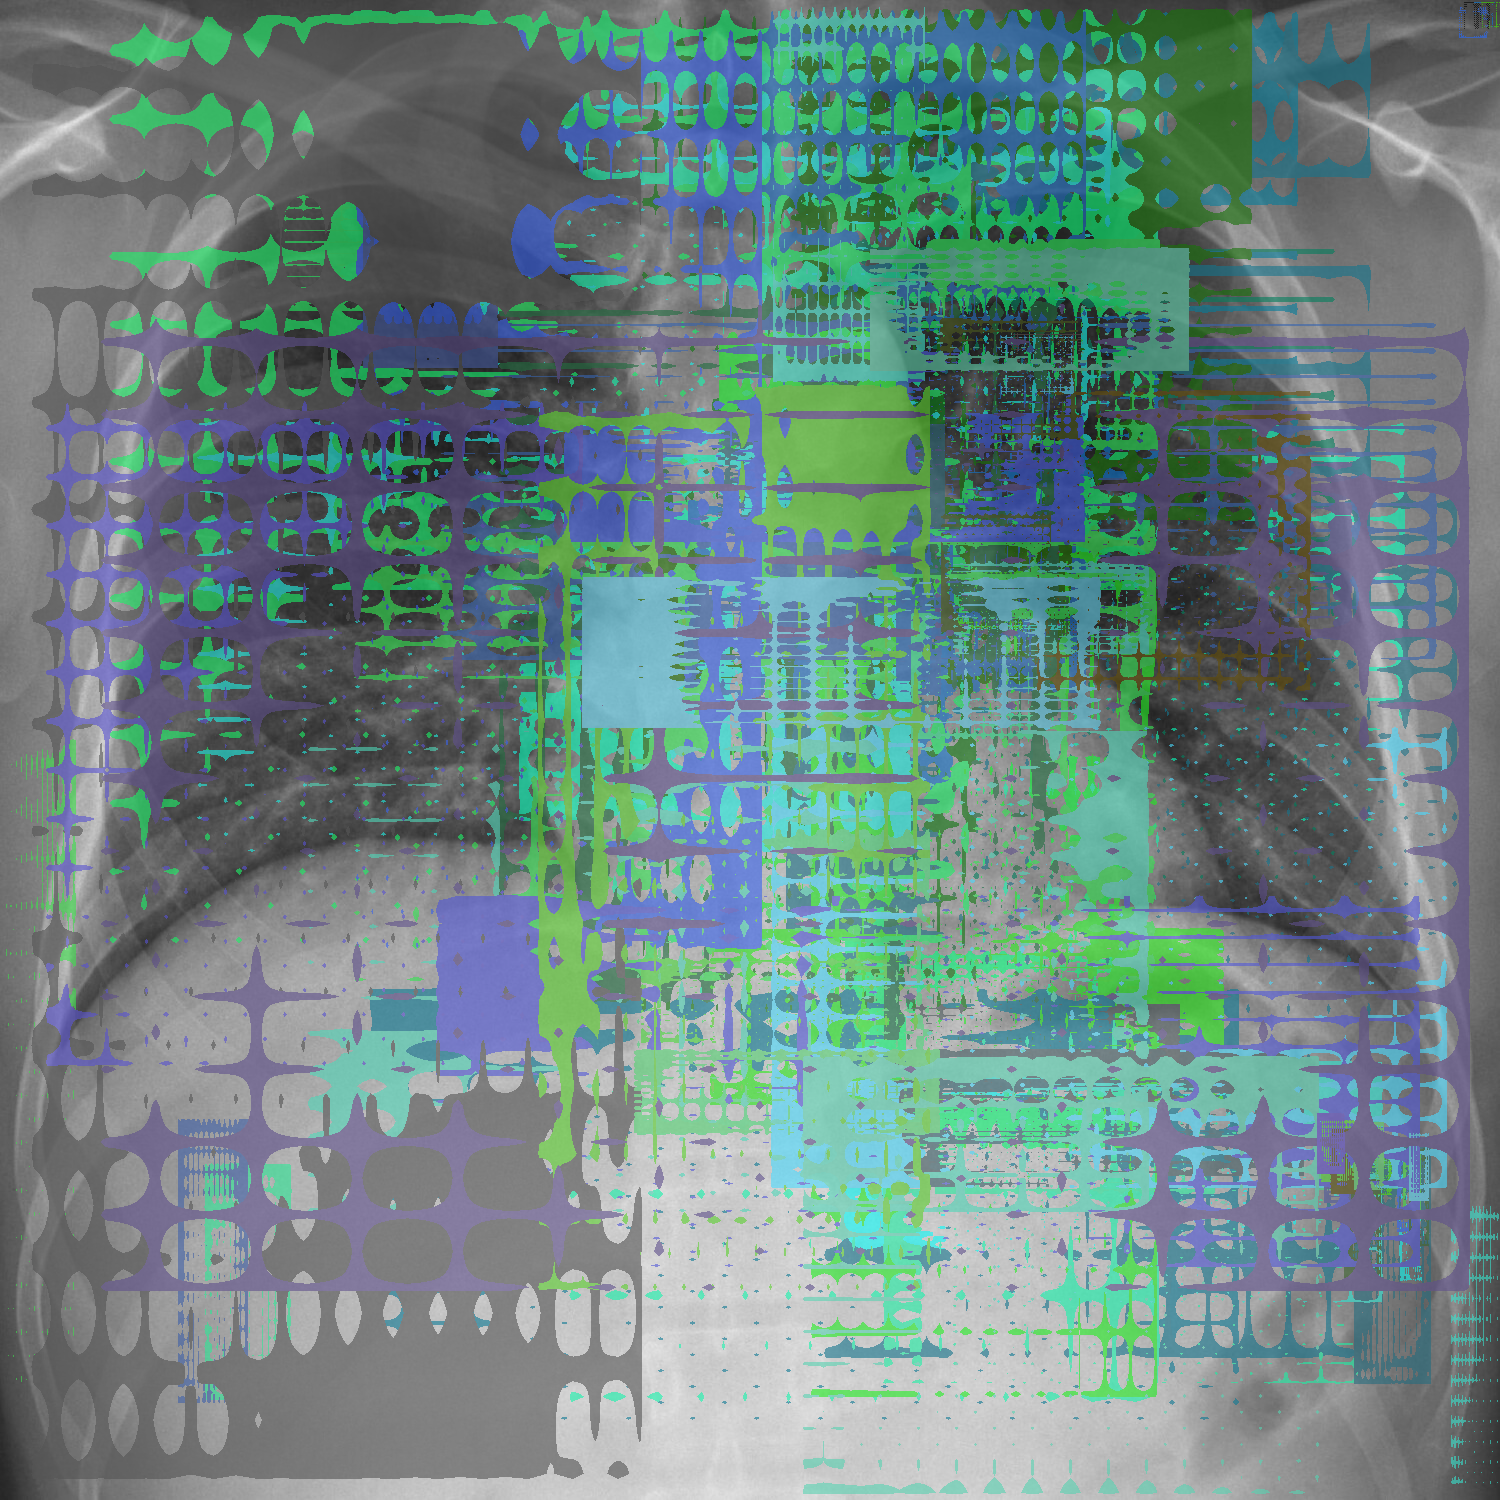

In [94]:
mask_on_image(byte_img, prediction, th=0.9)

In [ ]:
!rm -rf find -type d -name .ipynb_checkpoints

In [ ]:
'''
import numpy as np
import json
import cv2
'''

In [ ]:
'''
f = open("/content/drive/MyDrive/test_ribs_json.json", "r")
data = json.load(f)
'''

In [ ]:
'''
img_dir = "/content/drive/MyDrive/dataset_test"
mask_dir = "/content/drive/MyDrive/mask/"
'''

In [ ]:
'''
for k, v in data.items():
  filename = v['filename']

  img_path = f"{img_dir}/{filename}"
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  h, w, _ = img.shape

  mask = np.zeros((h, w))



  regions = v["regions"]
  for region in regions:
    shape_attr = region["shape_attributes"]
    x_points = shape_attr["all_points_x"]
    y_points = shape_attr["all_points_y"]

    contours = []
    for x,y in zip(x_points, y_points):
      contours.append((x,y))
    contours = np.array(contours)

    cv2.drawContours(mask, [contours], -1, 255, -1)
  cv2.imwrite(f"{mask_dir}/{filename}", mask)
  '''